# 6- Lasso Regression

## TEORİ

**Temel amaç, ürettiği modelin tahmin doğruluğunu ve yorumlanabilirliğini arttırmak için hem değişken seçimi hem de regularization yapar.**

* Aynı ridge regresyonda olduğu gibi amaç hata kareler toplamını minimize eden katsayıları, katsayılara ceza uygularayarak bulmaktır. Fakat ridge regresyondan farklı olarak ilgisiz değişkenlerin katsayılarını sıfıra eşitler.

## UYGULAMA

### Verisetinin İncelenmesi ve Manipüle Edilmesi

* Kullanılan Kütüphaneler

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category = UserWarning)

* Verisetinin İncelenmesi

Verisetini [buradan](https://mrkizmaz-s3data.s3.eu-west-1.amazonaws.com/DataSets/Hitters.csv) indirebilirsiniz.

In [2]:
hit = pd.read_csv("https://mrkizmaz-s3data.s3.eu-west-1.amazonaws.com/DataSets/Hitters.csv")
df = hit.copy()
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [3]:
df.isnull().values.any() # verisetinde bos degerler var mı?

True

In [4]:
df = df.dropna(axis = 0) # bos degerler olan satırları siler
df.isnull().values.any()

False

In [5]:
df.info() # veriseti hakkında genel bilgi verir

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 
dtypes: float64

In [6]:
df.describe().T # verisetinin istatistiksel dagılımı hakkında bilgi verir

,count,mean,std,min,25%,50%,75%,max
AtBat,263.0,403.642586,147.307209,19.0,282.5,413.0,526.0,687.0
Hits,263.0,107.828897,45.125326,1.0,71.5,103.0,141.5,238.0
HmRun,263.0,11.619772,8.757108,0.0,5.0,9.0,18.0,40.0
Runs,263.0,54.745247,25.539816,0.0,33.5,52.0,73.0,130.0
RBI,263.0,51.486692,25.882714,0.0,30.0,47.0,71.0,121.0
Walks,263.0,41.114068,21.718056,0.0,23.0,37.0,57.0,105.0
Years,263.0,7.311787,4.793616,1.0,4.0,6.0,10.0,24.0
CAtBat,263.0,2657.543726,2286.582929,19.0,842.5,1931.0,3890.5,14053.0
CHits,263.0,722.186312,648.199644,4.0,212.0,516.0,1054.0,4256.0
CHmRun,263.0,69.239544,82.197581,0.0,15.0,40.0,92.5,548.0


In [7]:
df.corr() # verisetinin degiskenleri arasındaki korelasyon

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
AtBat,1.000000,0.963969,0.555102,0.899829,0.796015,0.624448,0.012725,0.207166,0.225341,0.212422,0.237278,0.221393,0.132926,0.309607,0.342117,0.325577,0.394771
Hits,0.963969,1.000000,0.530627,0.910630,0.788478,0.587311,0.018598,0.206678,0.235606,0.189364,0.238896,0.219384,0.122971,0.299688,0.303975,0.279876,0.438675
HmRun,0.555102,0.530627,1.000000,0.631076,0.849107,0.440454,0.113488,0.217464,0.217496,0.492526,0.258347,0.349858,0.227183,0.250931,-0.161602,-0.009743,0.343028
Runs,0.899829,0.910630,0.631076,1.000000,0.778692,0.697015,-0.011975,0.171811,0.191327,0.229701,0.237831,0.202335,0.163700,0.271160,0.179258,0.192609,0.419859
RBI,0.796015,0.788478,0.849107,0.778692,1.000000,0.569505,0.129668,0.278126,0.292137,0.442190,0.307226,0.387777,0.233619,0.312065,0.062902,0.150155,0.449457
Walks,0.624448,0.587311,0.440454,0.697015,0.569505,1.000000,0.134793,0.269450,0.270795,0.349582,0.332977,0.312697,0.429140,0.280855,0.102523,0.081937,0.443867
Years,0.012725,0.018598,0.113488,-0.011975,0.129668,0.134793,1.000000,0.915681,0.897844,0.722371,0.876649,0.863809,0.837524,-0.020019,-0.085118,-0.156512,0.400657
CAtBat,0.207166,0.206678,0.217464,0.171811,0.278126,0.269450,0.915681,1.000000,0.995057,0.801676,0.982747,0.950730,0.906712,0.053393,-0.007897,-0.070478,0.526135
CHits,0.225341,0.235606,0.217496,0.191327,0.292137,0.270795,0.897844,0.995057,1.000000,0.786652,0.984542,0.946797,0.890718,0.067348,-0.013144,-0.068036,0.548910
CHmRun,0.212422,0.189364,0.492526,0.229701,0.442190,0.349582,0.722371,0.801676,0.786652,1.000000,0.825625,0.927903,0.810878,0.093822,-0.188886,-0.165369,0.524931


In [8]:
# Verisetindeki kategorik degiskenleri sürekli degiskenlere cevirmek gerekir,
dummy = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummy.head()

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,0,1,0,1,0,1
2,1,0,0,1,1,0
3,0,1,1,0,0,1
4,0,1,1,0,0,1
5,1,0,0,1,1,0


In [9]:
# anaveriseti icerisindeki kategorik degiskenler silinmeli
df1 = df.drop(['League', 'Division', 'NewLeague'], axis = 1)
df1.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0


In [10]:
# dummy ve df1 verisetleri birlestirilerek güncel veriseti olusturulur,
df = pd.concat([df1, dummy[['League_N', 'Division_W', 'NewLeague_N']]], axis = 1)
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,1,1,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,0,1,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0,1,0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5,1,0,1
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0,0,1,0


### Model Kurulumu

In [11]:
X = df.drop('Salary', axis = 1) # bagımsız degiskenler (salary dısındaki degiskenleri alır)
y = df['Salary'] # bagımlı degiskenler

# %80 egitim, %20 test seti,
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size = 0.20,
                                                   random_state = 42)
# alpha degeri 0.1 olarak model nesnesı ve fit edilmesi
lasso_model = Lasso(alpha = 0.1).fit(X_train, y_train)
lasso_model

Lasso(alpha=0.1)

In [12]:
lasso_model.intercept_ # sabit deger

13.381413225064648

In [13]:
lasso_model.coef_ # katsayı degerleri

array([  -1.43673183,    7.22922383,    4.52070259,   -2.69258341,
         -1.39179202,    5.49466544,    9.11216761,   -0.25552181,
          0.22651097,   -0.28773139,    1.62410937,    0.87535174,
         -0.79567609,    0.24668051,    0.23241433,   -0.64850633,
        106.83448227, -113.53593674,  -62.04160175])

In [14]:
rscore = lasso_model.score(X_train, y_train) # modelin anlamlılık(basarı) degeri

In [15]:
rscore # [önemli]

0.5903998100755615

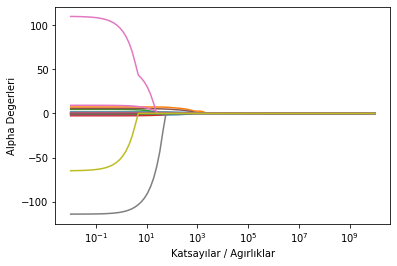

In [32]:
# farklı alpha degerlerinde model olusturulması,

lasso = Lasso()
alphalar = 10 ** np.linspace(10, -2, 100) * 0.5 # random alpha degerleri
katsayilar = []

for i in alphalar:
    lasso.set_params(alpha = i)
    lasso.fit(X_train, y_train)
    katsayilar.append(lasso.coef_)
    
# Degerlerin Görsellestirilmesi
ax = plt.gca()
ax.plot(alphalar * 2, katsayilar)
ax.set_xscale('log')

plt.axis('tight')
plt.ylabel('Alpha Degerleri')
plt.xlabel('Katsayılar / Agırlıklar');

* Katsayıları 0 yapar!

In [17]:
min(katsayilar[0])

0.0

In [18]:
rscore2 = lasso.score(X_train, y_train) # modelin basarı degeri

In [19]:
rscore2 # [önemli]

0.5903996612241988

### Tahminleme

In [33]:
# alpha = 0.1 (ilk model) icin hata degeri
ypred = lasso_model.predict(X_test)
mse = mean_squared_error(y_test, ypred) # MSE
rmse = np.sqrt(mse) # hata degeri (RMSE)

In [34]:
rmse

358.6413958431205

In [35]:
# coklu alpha icin (ikinci model) hata degeri
ypred2 = lasso.predict(X_test)
rmse2 = np.sqrt(mean_squared_error(y_test, ypred2))

In [23]:
rmse2

358.79240752268623

In [36]:
print(f"Alpha: 0.1 icin elde edilen degerler; \nModelin basarı yüzdesi: {rscore * 100} \nModelin hata degeri: {rmse}")
print(f"Coklu alpha degerleri icin elde edilen degerler; \nModelin basarı yüzdesi: {rscore2 * 100} \nModelin hata degeri: {rmse2}")

Alpha: 0.1 icin elde edilen degerler; 
Modelin basarı yüzdesi: 59.03998100755615 
Modelin hata degeri: 358.6413958431205
Coklu alpha degerleri icin elde edilen degerler; 
Modelin basarı yüzdesi: 59.039966122419884 
Modelin hata degeri: 358.79240752268623


* Bu şekilde optimum hata degeri elde edilemez, model tuning uygulanır.

### Model Tuning / Model Doğrulama

In [37]:
# optimum alpha degerinin bulunması ve final modelinin olusturulması,
lasso_cv = LassoCV(alphas = None,
                  cv = 10,
                  max_iter = 10000,
                  normalize = True)
lassocv_model = lasso_cv.fit(X_train, y_train)
lassocv_model

/home/mrkizmaz/.local/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


LassoCV(cv=10, max_iter=10000, normalize=True)

In [38]:
# final modeli olusturularak test hatasının bulunması,
lasso_final = Lasso(alpha = lassocv_model.alpha_)
model_final = lasso_final.fit(X_train, y_train)
ypred_final = model_final.predict(X_test)
rmse3 = np.sqrt(mean_squared_error(y_test, ypred_final))

In [39]:
rmse3

358.60412684844744

In [40]:
rscore3 = model_final.score(X_train, y_train)

In [41]:
rscore3

0.5903989653124817

In [42]:
print(f"Optimum alpha degeri icin elde edilen degerler; \nModelin basarı yüzdesi: {rscore3 * 100} \nModelin hata degeri: {rmse3}")

Optimum alpha degeri icin elde edilen degerler; 
Modelin basarı yüzdesi: 59.03989653124817 
Modelin hata degeri: 358.60412684844744


### Sonuç

* Alpha: 0.1 icin elde edilen degerler; 
    * Modelin basarı yüzdesi: 59.03998100755615 
    * Modelin hata degeri: **358.6413958431205**
* Coklu alpha degeleri icin elde edilen degerler; 
    * Modelin basarı yüzdesi: 59.039966122419884 
    * Modelin hata degeri: **358.79240752268623**
* Optimum alpha degeri icin elde edilen degerler; 
    * Modelin basarı yüzdesi: 59.03989653124817 
    * Modelin hata degeri: **358.60412684844744**

* Aynı veriseti üzerinde,
    * PCR regresyon modelinde optimum hata degeri: **333.6546715301251** olarak bulundu.
    * PLC regresyon modelinde optimum hata degeri: **333.60890630848354** olarak bulundu.
    * Ridge regresyon modelinde optimum hata degeri: **383.0073770592842** olarak bulundu.